# Cómo conseguir el primer empleo de Data Analyst

Si estás (como yo) dando tus primeros pasos en el mundo de Data, habrás ido conociendo de a poco distintas tecnologías, lenguajes de programación, herramientas y procesos propios de la actividad. Luego de un tiempo, seguro tienes la sensación de que la lista de skills posibles a incorporar es tan larga que abruma. Aprenderlas todas llevaría más tiempo y esfuerzo del que somos capaces de asumir en la vida... Y es así que entramos en un espiral de frustración infinita en el cual por cada cosa nueva que aprendemos, descubrimos muchas otras que alargan aún más la lista de habilidades por adquirir. Lógicamente este es el momento en que entendemos que es mejor dedicarse a otra cosa y ser felices. Bueno en realidad no es para tanto.

La clave está en establecer prioridades. Para establecer prioridades necesitamos información. La información la podemos obtener aplicando algo de Data Analytics. Y así cerramos el bucle.

Claramente el hito que estamos persiguiendo es conseguir nuestro primer empleo como Analistas de Datos. Seguramente haya más, pero en principio veo 2 caminos bien definidos para lograrlo:

1. Trabajando duro: Aprender todo lo que nuestro cerebro pueda y luego encontrar las vacantes a las que se ajuste nuestro perfil (prestando especial atención a no morir en el intento).

2. Trabajando inteligentemente: Usar lo que ya sabemos sobre Data Analytics, tomar datos del mercado laboral que nos permitan detectar las skills más requeridas por las vacantes que nos interesan y enfocarnos en dominarlas.

Como somos inteligentes, vamos a ir por el 2do camino. Y la idea es la que sigue.

Utilizando un script escrito en Python para hacer scrapping en LinkedIn, obtenemos un .csv con la información de todas las búsquedas activas para el puesto de "Data Analyst". En este caso, voy a analizar el mercado laboral de Argentina. Con este dataset, voy a intentar responder las siguientes cuestiones:

* ¿Cuáles son las empresas con más vacantes/búsquedas activas?
* ¿A qué sectores de la economía pertenecen?
* ¿Cuál es la distribución entre vacantes para trabajar Remoto, Presencial o Híbrido?
* ¿Qué nivel de experiencia previa se requiere a los postulantes?
* ¿Qué tipo de relación contractual ofrecen las empresas?
* ¿Cuáles son las herramientas tecnológicas más solicitadas? 


In [9]:
import pandas as pd
from pandas_profiling import ProfileReport
import json
import numpy as np

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

arg = pd.read_csv(r"https://raw.githubusercontent.com/JuanPabloVeliz/LinkedIn_DA/main/Datasets/linkedin-jobs-Argentina.csv")
arg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1094 non-null   object 
 1   company        1094 non-null   object 
 2   description    1094 non-null   object 
 3   onsite_remote  1094 non-null   object 
 4   salary         0 non-null      float64
 5   location       1094 non-null   object 
 6   criteria       1094 non-null   object 
 7   posted_date    1094 non-null   object 
 8   link           1094 non-null   object 
dtypes: float64(1), object(8)
memory usage: 77.0+ KB


In [10]:
arg.head(15)

,title,company,description,onsite_remote,salary,location,criteria,posted_date,link
0,Data Analyst,Baufest,Job DescriptionEn Baufest queremos mejorar la ...,Presencial,NaN,Argentina,"[{'Nivel de antigüedad': 'Sin experiencia'}, {...",2022-11-23,https://ar.linkedin.com/jobs/view/data-analyst...
1,Jr. Master Data Analyst,The AES Corporation,"En AES, elevamos la calidad de vida en todo el...",Presencial,NaN,"Buenos Aires, Buenos Aires Province, Argentina","[{'Nivel de antigüedad': 'Intermedio'}, {'Tipo...",2022-12-19,https://ar.linkedin.com/jobs/view/jr-master-da...
2,Data Analyst,Level Access,"If you are passionate about data, and you clea...",Presencial,NaN,"Buenos Aires, Buenos Aires Province, Argentina","[{'Nivel de antigüedad': 'Sin experiencia'}, {...",2022-12-01,https://ar.linkedin.com/jobs/view/data-analyst...
3,BI DATA ANALYST (TABLEAU) | REMOTO | ARGENTINA,Empleos IT,Consultora especializada en Business Intellige...,Presencial,NaN,"Autonomous City of Buenos Aires, Buenos Aires ...","[{'Nivel de antigüedad': 'Intermedio'}, {'Tipo...",2022-11-29,https://ar.linkedin.com/jobs/view/bi-data-anal...
4,analista de datos,Nini Mayorista,Nini Mayorista incorpora a su equipo perfil co...,Presencial,NaN,"Moreno, Buenos Aires Province, Argentina","[{'Nivel de antigüedad': 'Sin experiencia'}, {...",2022-10-28,https://ar.linkedin.com/jobs/view/analista-de-...
5,Global Data Analyst,Givaudan,Join us and celebrate the beauty of human expe...,Presencial,NaN,"Martínez, Buenos Aires Province, Argentina","[{'Nivel de antigüedad': 'No corresponde'}, {'...",2022-12-04,https://ar.linkedin.com/jobs/view/global-data-...
6,Clinical Data Analyst,Cognizant,"At #Cognizant, we have an ideal opportunity fo...",Presencial,NaN,"Buenos Aires Province, Argentina","[{'Nivel de antigüedad': 'Sin experiencia'}, {...",2022-12-14,https://ar.linkedin.com/jobs/view/clinical-dat...
7,Analista de Datos,Megatlon,En Megatlon nos encontramos en la búsqueda de ...,Presencial,NaN,"Buenos Aires, Buenos Aires Province, Argentina","[{'Nivel de antigüedad': 'Intermedio'}, {'Tipo...",2022-12-12,https://ar.linkedin.com/jobs/view/analista-de-...
8,Analista Datos SQL y Tableros,Educ.ar Sociedad del Estado,Principales tareas y responsabilidades asignad...,Presencial,NaN,"Buenos Aires, Buenos Aires Province, Argentina","[{'Nivel de antigüedad': 'Intermedio'}, {'Tipo...",2022-10-29,https://ar.linkedin.com/jobs/view/analista-dat...
9,Data Analyst,JLL,"JLL Supports The Whole You, Personally And Pro...",Presencial,NaN,"Buenos Aires, Buenos Aires Province, Argentina","[{'Nivel de antigüedad': 'Sin experiencia'}, {...",2022-12-19,https://ar.linkedin.com/jobs/view/data-analyst...


In [11]:
arg.duplicated(subset=arg.drop(columns="link").columns).value_counts()

True     896
False    198
dtype: int64

## Transformaciones al dataset
Un primer vistazo a la información ya nos pone a trabajar en algunas transformaciones necesarias.

En primer lugar la columna "criteria" contiene varios datos que será mejor enviar a columnas independientes. Una vez realizado, ya no la necesitamos.

También noto que en la columna "description" hay celdas con los caracteres "Nan" en formato string. Eso puede dar problemas así que los reemplazo por None.

Y lamentablemente, en las publicaciones ninguna empresa indicó información para "salary", por lo que la elimino.

Y lamentablemente II, la mayoría de las publicaciones están duplicadas. Sólo hay 198 búsquedas "reales".

In [12]:
def extract_criteria(x, crit):
    d = json.loads(x.replace("\'", "\""))

    existe = []
    for item in d:
        existe.append(crit in item in d)

    if bool(True in existe):
        pos = existe.index(True)
        return d[pos][crit]
    
arg["nivel de antigüedad"] = arg["criteria"].apply(extract_criteria, crit="Nivel de antigüedad")
arg["tipo de empleo"] = arg["criteria"].apply(extract_criteria, crit="Tipo de empleo")
arg["función laboral"] = arg["criteria"].apply(extract_criteria, crit="Función laboral")
arg["sector"] = arg["criteria"].apply(extract_criteria, crit="Sectores")

arg = arg.drop(columns=["criteria", "salary"])

arg["description"].replace("Nan", None, inplace=True)

arg.drop_duplicates(subset=arg.drop(columns="link").columns, inplace=True)

arg.reset_index(drop=True, inplace=True)


## Exprimiendo aún mas los datos

El desafío ahora es identificar si las descripciones de las vacantes hacen referencia a alguna herramienta tecnológica. Para eso creo una lista de herramientas y verifico si el nombre aparece en la descripción. Para cada herramienta creo unanueva columna en la que se indica True si la vacante la nombra y False en caso contrario. Si la vacante no tiene una descripción, se completa con None.

In [23]:
def includes_stack(x, to_check):
    if x is not None:
        return (str.casefold(to_check) in str.casefold(x))

tech_stack= ["Excel ", "Power BI", "Microstrategy", "Tableau", "Qlikview", "Embulk", "Airflow", "Redash", "Rapidminer", "SQL", "MongoDB", "DynamoDB", "Cassandra", "Python", " R ", "Julia", "PySpark", "Hadoop", "Snowflake", "Hive", "Azure", "AWS", "Google Cloud"]

for stack in tech_stack:
    arg[stack]= arg["description"].apply(includes_stack, to_check=stack)


In [14]:
arg.sample(5)

,title,company,description,onsite_remote,location,posted_date,link,nivel de antigüedad,tipo de empleo,función laboral,sector,Excel,Power BI,Microstrategy,Tableau,Qlikview,Embulk,Airflow,Redash,Rapidminer,SQL,MongoDB,DynamoDB,Cassandra,Python,R,Julia,PySpark,Hadoop,Snowflake,Hive,Azure,AWS,Google Cloud
186,BI Analytics Jr.,Wenance,None,Híbrido,"Vicente López, Buenos Aires Province, Argentina",2022-12-14,https://ar.linkedin.com/jobs/view/bi-analytics...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
15,Analista de datos - Mix (On Site & Remoto) (1236),aliantec,¿Qué hace la compañía?Importante Grupo Bancari...,Presencial,"Autonomous City of Buenos Aires, Buenos Aires ...",2022-11-23,https://ar.linkedin.com/jobs/view/analista-de-...,Sin experiencia,Jornada completa,Tecnología de la información,Servicios de TI y consultoría de TI,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False
89,Data Engineer,Intermedia,Job DescriptionWe are looking for a dynamic an...,Remoto,Argentina,2022-12-02,https://ar.linkedin.com/jobs/view/data-enginee...,Intermedio,Jornada completa,Tecnología de la información,Servicios de TI y consultoría de TI,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False
189,Business Intelligence Analyst,ICBC Argentina,None,Híbrido,Greater Buenos Aires,2022-11-30,https://ar.linkedin.com/jobs/view/business-int...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
114,Senior Data Engineer (Anywhere),Globant,We are a digitally native technology services ...,Remoto,Argentina,2022-11-21,https://ar.linkedin.com/jobs/view/senior-data-...,Intermedio,Jornada completa,Tecnología de la información,Servicios de TI y consultoría de TI,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True


## De los Datos a la Información

Ahora que tenemos los datos organizados, podemos comenzar a extraer las respuestas que necesitamos.

### ¿Cuáles son las empresas con más vacantes/búsqueda activas?

<AxesSubplot:title={'center':'Cantidad de búsquedas por Empresa'}, ylabel='Empresa'>

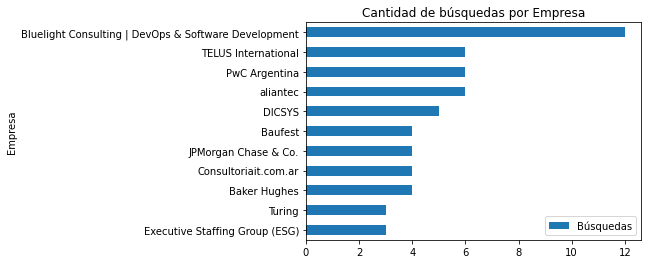

In [17]:
import matplotlib.pyplot as plt


top_companies = pd.DataFrame(arg["company"].value_counts().sort_values(ascending=False))
top_companies.rename(columns={"company": "Búsquedas"}, inplace=True)
top_companies.reset_index(inplace=True)
top_companies.rename(columns={"index": "Empresa"}, inplace=True)
top_companies = top_companies.loc[0:10]

top_companies.sort_values("Búsquedas").plot(kind="barh", x="Empresa", title="Cantidad de búsquedas por Empresa")

### ¿Cuáles son los sectores con más busquedas activas?

<AxesSubplot:title={'center':'Cantidad de búsquedas por Sector'}, ylabel='Sector'>

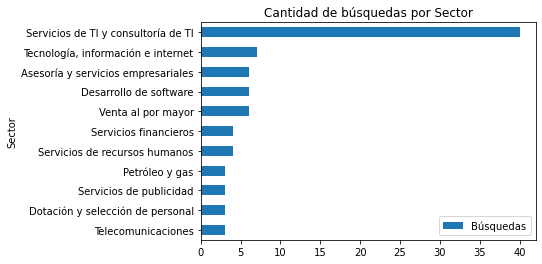

In [20]:
top_sectors = pd.DataFrame(arg["sector"].value_counts().sort_values(ascending=False))
top_sectors.rename(columns={"sector": "Búsquedas"}, inplace=True)
top_sectors.reset_index(inplace=True)
top_sectors.rename(columns={"index":"Sector"}, inplace=True)
top_sectors = top_sectors.loc[0:10]

top_sectors.sort_values("Búsquedas").plot(kind="barh", x="Sector", title="Cantidad de búsquedas por Sector")


### ¿Qué tipo de contratación ofrecen las empresas?

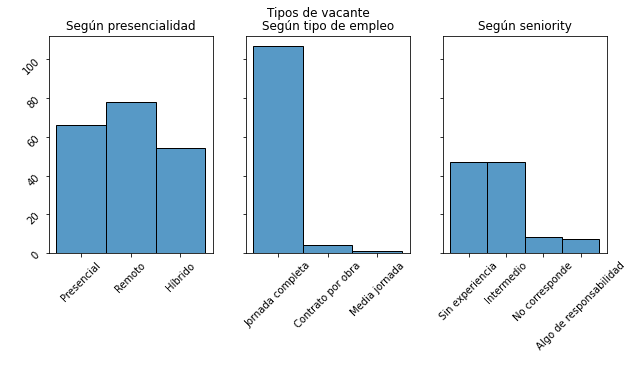

In [21]:
import seaborn as sns

fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True)

fig.suptitle("Tipos de vacante")
sns.histplot(arg["onsite_remote"], ax=axs[0]).set(title="Según presencialidad", xlabel=" ", ylabel=" ")
sns.histplot(arg["tipo de empleo"], ax=axs[1]).set(title="Según tipo de empleo", xlabel=" ")
sns.histplot(arg["nivel de antigüedad"], ax=axs[2]).set(title="Según seniority", xlabel=" ")
axs[0].tick_params(rotation=45)
axs[1].tick_params(rotation=45)
axs[2].tick_params(rotation=45)

### ¿Cuáles son las skills más requeridas?

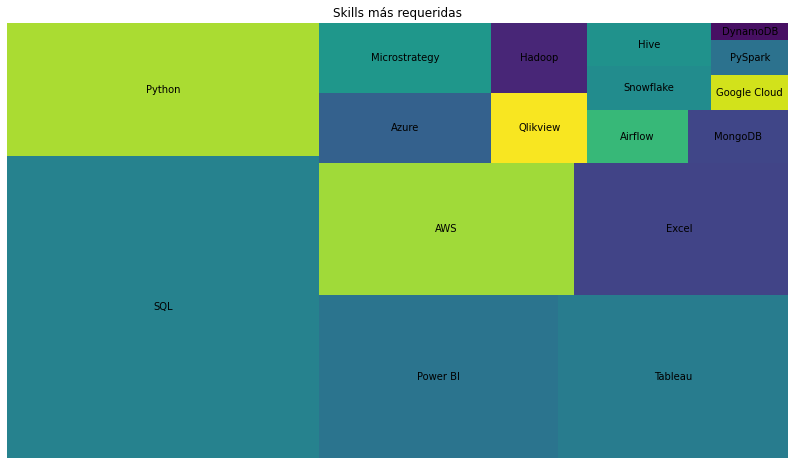

In [24]:
import matplotlib as mlp
import squarify

top_skills = pd.DataFrame(columns=["Menciones"])

for stack in tech_stack:
    top_skills.loc[stack] = len(arg[stack].loc[arg[stack] == True])

top_skills = top_skills.loc[top_skills["Menciones"] != 0].sort_values(by="Menciones", ascending=False)
top_skills = top_skills.reset_index()
top_skills.rename(columns={"index": "Skill"}, inplace=True)

fig, axs = plt.subplots(figsize=(14,8))

axs = squarify.plot(sizes=top_skills["Menciones"],  label=top_skills["Skill"], text_kwargs={'fontsize':10})
axs.axis('off')
axs.set(title="Skills más requeridas")
axs.tick_params(labelsize=10)
